In [0]:
import tensorflow as tf
import numpy as np
import pylab as plt
import pandas as pd

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
# Scale data
def scale(X):
    return (X-np.mean(X,axis=0)) / np.std(X,axis=0)

In [0]:
NUM_FEATURES = 7

hidden_neurons = 10
batch_size = 8
beta = 10**-3
learning_rate = 10**-3
epochs = 150000

seed = 42
np.random.seed(seed)

In [0]:
# Read data
data_input = np.genfromtxt('admission_predict.csv', delimiter= ',')
data_X, data_Y = data_input[1:,1:8], data_input[1:,-1]
# Scale X inputs
dataX = scale(data_X)
dataY = data_Y.reshape(data_Y.shape[0],1)

# Define the size of training set and data set
dataset_size = len(dataX)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size

# Shuffle the data before splitting to training and testing set
idx = np.arange(dataset_size)
np.random.shuffle(idx)
dataX = dataX[idx]
dataY = dataY[idx]

# Split the training and testing set
trainX = dataX[:train_size]
trainY = dataY[:train_size]

testX = dataX[train_size:]
testY = dataY[train_size:]

In [0]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, 1])

# Build the graph for the neural network
# Hidden layer with relu activation
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, hidden_neurons], stddev=1.0 / np.sqrt(NUM_FEATURES), dtype=tf.float32), name='weights')
b1 = tf.Variable(tf.zeros([hidden_neurons]), dtype=tf.float32, name='biases')
h1 = tf.nn.relu(tf.matmul(x, w1) + b1)

# Linear output layer
w2 = tf.Variable(tf.truncated_normal([hidden_neurons, 1], stddev=1.0 / np.sqrt(hidden_neurons), dtype=tf.float32), name='weights')
b2 = tf.Variable(tf.zeros([1]),dtype=tf.float32, name='biases')
y = tf.matmul(h1, w2) + b2  

In [0]:
# Regularization
regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)

# Regularized loss
loss = tf.reduce_mean(tf.square(y_ - y) + beta*regularization)

In [0]:
# Define the optimiser
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

# Create a variable to track the global step
global_step = tf.Variable(0, name='global_step', trainable=False)

# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
train_op = optimizer.minimize(loss, global_step=global_step)

In [0]:
N = train_size
idx_train = np.arange(N)

# Run the session
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  train_error =[]
  test_error =[]
  
  for i in range(epochs):
    # Shuffle the training data
    np.random.shuffle(idx_train) 
    trainX = trainX[idx_train]
    trainY = trainY[idx_train]
    
    for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
      train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
    
    train_error.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
    test_error.append(loss.eval(feed_dict={x: testX, y_: testY}))

    if i == 0 or (i+1)%5000 == 0:
      print('iter {}: train error  {}'.format(i+1, train_error[i]))
      print('iter {}: test error  {}'.format(i+1, test_error[i]))
      print()

iter 1: train error  0.58430016040802
iter 1: test error  0.5780889391899109

iter 5000: train error  0.00620268564671278
iter 5000: test error  0.006818003486841917

iter 10000: train error  0.0054293349385261536
iter 10000: test error  0.005827727727591991

iter 15000: train error  0.004985271953046322
iter 15000: test error  0.005264091305434704

iter 20000: train error  0.004699889570474625
iter 20000: test error  0.0049409023486077785

iter 25000: train error  0.00448371097445488
iter 25000: test error  0.00471041165292263

iter 30000: train error  0.004299437627196312
iter 30000: test error  0.004533296916633844

iter 35000: train error  0.004170279949903488
iter 35000: test error  0.004425675608217716

iter 40000: train error  0.004058993887156248
iter 40000: test error  0.004340378567576408

iter 45000: train error  0.003974443767219782
iter 45000: test error  0.0042689042165875435

iter 50000: train error  0.003917704336345196
iter 50000: test error  0.004231365397572517

iter

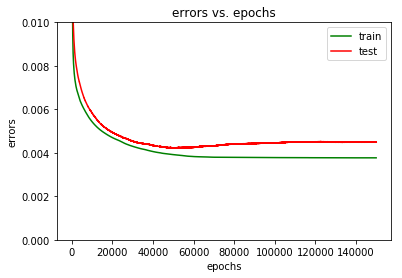

In [0]:
# Plot learning curves
plt.figure()
plt.title('errors vs. epochs')
plt.plot(range(epochs), train_error,'g',label='train')
plt.plot(range(epochs), test_error,'r',label='test')
plt.xlabel('epochs')
plt.ylabel('errors')
plt.legend(loc='best')
plt.ylim((0,0.01))

plt.show()

In [0]:
min_test_error = min(test_error)
opt_epoch = test_error.index(min_test_error)
print("Min test error:", min_test_error)
print("Optimal epoch:",opt_epoch)

Min test error: 0.004224059
Optimal epoch: 50648


In [0]:
N = train_size
idx_train = np.arange(N)

# Run the session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
  
#test_error =[]
  
for i in range(50648):
  # Shuffle the training data
  np.random.shuffle(idx_train) 
  trainX = trainX[idx_train]
  trainY = trainY[idx_train]
    
  for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
    sess.run(train_op, {x:trainX[start:end], y_:trainY[start:end]})

In [0]:
# Predict on test set
predicted = sess.run(y, {x:testX, y_:testY})

In [0]:
target_prediction_df = pd.DataFrame({'Target': np.array(testY).flatten(), 'Predicted': np.array(predicted).flatten()})

In [0]:
target_prediction_df

Target  Predicted
0      0.65   0.625516
1      0.76   0.684222
2      0.70   0.498234
3      0.71   0.725451
4      0.63   0.709400
5      0.79   0.772239
6      0.96   0.970133
7      0.89   0.867293
8      0.90   0.905569
9      0.93   0.919475
10     0.47   0.601845
11     0.89   0.889805
12     0.91   0.868882
13     0.73   0.673923
14     0.73   0.689215
15     0.79   0.773859
16     0.44   0.548273
17     0.78   0.774559
18     0.73   0.731009
19     0.87   0.863999
20     0.82   0.796837
21     0.67   0.658229
22     0.72   0.605069
23     0.80   0.799659
24     0.54   0.655199
25     0.82   0.750717
26     0.84   0.824173
27     0.50   0.556634
28     0.52   0.689527
29     0.62   0.589406
..      ...        ...
90     0.47   0.461507
91     0.88   0.873872
92     0.71   0.708228
93     0.70   0.618141
94     0.67   0.575572
95     0.57   0.535806
96     0.89   0.921379
97     0.87   0.840250
98     0.64   0.571280
99     0.59   0.629664
100    0.78   0.729806
101    0.69   0.681121
102    0.79   0.632958
103    0.96   0.932285
104    0.94   0.918339
105    0.81   0.611012
106    0.79   0.810081
107    0.95   0.942922
108    0.66   0.614619
109    0.80   0.738363
110    0.94   0.912066
111    0.94   0.926782
112    0.95   0.950271
113    0.64   0.635537
114    0.93   0.891705
115    0.96   0.959325
116    0.87   0.866837
117    0.72   0.669863
118    0.57   0.436665
119    0.62   0.624378

[120 rows x 2 columns]

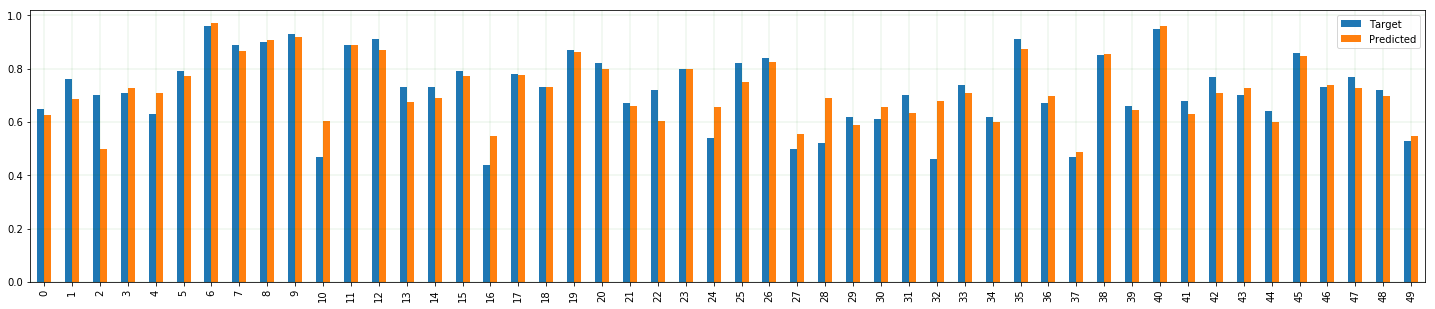

In [0]:
target_prediction_50_df = target_prediction_df.head(50)
target_prediction_50_df.plot(kind='bar',figsize=(25,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()